<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/WI_CLASSIFIER_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#settings
batch_size = 128
validation_split = .3
shuffle_dataset = True
random_seed= 42

criterion = nn.CrossEntropyLoss()

n_epochs = 30
print_every = 1


AE_encoded_dim = 64


seq_len=200

DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA"
DATA_SONG_DIR = "originals"
DATA_IMG_DIR = "originals"
input_bins = 12
BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/ORIGINAL_CHROMA/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA"
# DATA_SONG_DIR = "Activations_64"
# DATA_IMG_DIR = "Activations_64"
# input_bins = 64
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/LAYER1_64_CHROMA/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA"
# DATA_SONG_DIR = "Activations_128"
# DATA_IMG_DIR = "Activations_128"
# input_bins = 128
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/LAYER2_128_CHROMA/"

# DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA"
# DATA_SONG_DIR = "reconstructions"
# DATA_IMG_DIR = "reconstructions"
# input_bins = 12
# BASE_PATH = "/content/gdrive/My Drive/vajra/WI_CLASSIFIER_V1/reconstructions_CHROMA/"


TEST_DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1"
TEST_DATA_SONG_DIR = "reconstructions"
TEST_DATA_IMG_DIR = "reconstructions"

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
print(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "Western_numpy"))
             
train_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      train_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
train_files = random.sample(train_files, len(train_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", "Indian_numpy")):
  for file in fileList:
    if(True):
      train_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

train_data = pd.DataFrame(train_files, columns=['Images','songs','labels'])
train_data.head()

/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/originals/Western_numpy


,Images,songs,labels
0,2405.npy,2405.npy,Western_numpy
1,1097.npy,1097.npy,Western_numpy
2,672.npy,672.npy,Western_numpy
3,1002.npy,1002.npy,Western_numpy
4,238.npy,238.npy,Western_numpy


In [ ]:
train_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,1405,1405
Western_numpy,1406,1406


In [ ]:
test_files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      test_files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
test_files = random.sample(test_files, len(test_files))

for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test", "Indian_numpy")):
  for file in fileList:
    if(True):
      test_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

test_data = pd.DataFrame(test_files, columns=['Images','songs','labels'])
test_data.head()

,Images,songs,labels
0,902.npy,902.npy,Western_numpy
1,213.npy,213.npy,Western_numpy
2,10.npy,10.npy,Western_numpy
3,167.npy,167.npy,Western_numpy
4,1195.npy,1195.npy,Western_numpy


In [ ]:
test_data.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,603,603
Western_numpy,602,602


/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/CHROMA/originals/training/Western_numpy/828.npy


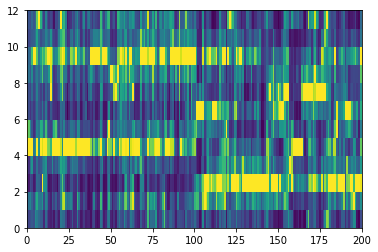

In [ ]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training", train_data.loc[test_idx, 'labels'], train_data.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

import matplotlib.pyplot as plt

plt.pcolormesh(numpy_arr)



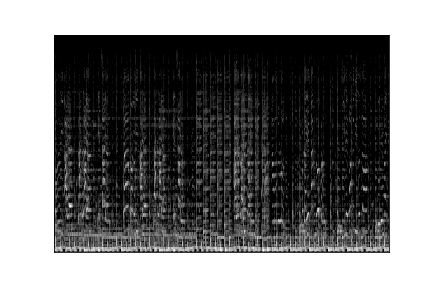

In [ ]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [ ]:
lb = LabelEncoder()
train_data['encoded_labels'] = lb.fit_transform(train_data['labels'])
train_data.head()

,Images,songs,labels,encoded_labels
0,2405.npy,2405.npy,Western_numpy,1
1,1097.npy,1097.npy,Western_numpy,1
2,672.npy,672.npy,Western_numpy,1
3,1002.npy,1002.npy,Western_numpy,1
4,238.npy,238.npy,Western_numpy,1


In [ ]:
test_data['encoded_labels'] = lb.transform(test_data['labels'])
test_data.head()

,Images,songs,labels,encoded_labels
0,902.npy,902.npy,Western_numpy,1
1,213.npy,213.npy,Western_numpy,1
2,10.npy,10.npy,Western_numpy,1
3,167.npy,167.npy,Western_numpy,1
4,1195.npy,1195.npy,Western_numpy,1


In [ ]:
classes = ('Indian_numpy', 'Western_numpy')
train_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [ ]:
test_data.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [ ]:
from sklearn.model_selection import train_test_split

train_data = train_data.sample(frac=1)
test_data = test_data.sample(frac=1)


#df_train, df_test = train_test_split(data, test_size=validation_split, stratify=data[["labels"]])

df_train = train_data.reset_index(drop=True)
df_test = test_data.reset_index(drop=True)

In [ ]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [ ]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [ ]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [ ]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        return data, label



In [ ]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "training"),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, "test"),transform)

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg.squeeze()

def mel_display(S_DB):
    #print(S_DB.shape)
    S_DB = S_DB.numpy()
    array = S_DB*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array

    array = np.transpose(array, (1, 2, 0))
    return array.squeeze()

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    array = npimg*-1
    #print(array.max())
    array *= (255.0/array.max())
    array = 255 - array
    array = np.transpose(array, (1, 2, 0))
    plt.imshow(array.squeeze(), interpolation='nearest', aspect='auto')
    plt.show()

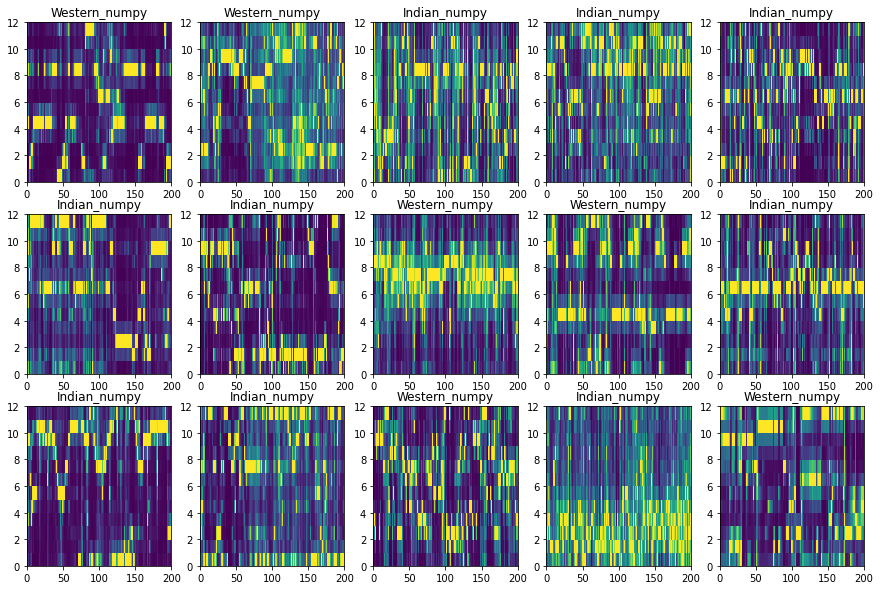

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

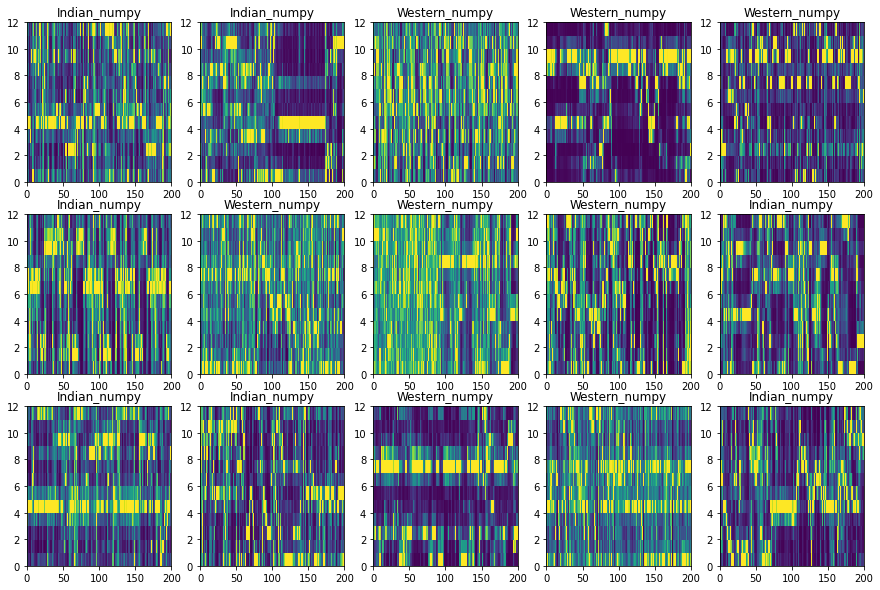

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.pcolormesh(image.permute(1, 0)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        if input_bins == 12:
          self.fc1 = nn.Linear(768, 120)
        if input_bins == 64:
          self.fc1 = nn.Linear(10752, 120)
        if input_bins == 128:
          self.fc1 = nn.Linear(21808, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net()
# net.to(device)

In [ ]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
    self.fc1 = nn.Linear(n_features * self.seq_len, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 2)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(6, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=2400, bias=True)
    (fc1): Linear(in_features=2400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
best_accuracy = 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('Accuracy of the network on the train images after epoch {} is {}'.format(epoch, 100 * correct / total) )
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy_epoch = 100 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    if accuracy_epoch > best_accuracy:
      best_accuracy = accuracy_epoch
      torch.save(net.state_dict(), os.path.join(BASE_PATH, "best_model.pt"))
        
        
    

print('Finished Training')

[1,     1] loss: 0.693
[1,     2] loss: 0.693
[1,     3] loss: 0.698
[1,     4] loss: 0.687
[1,     5] loss: 0.689
[1,     6] loss: 0.695
[1,     7] loss: 0.693
[1,     8] loss: 0.686
[1,     9] loss: 0.697
[1,    10] loss: 0.697
[1,    11] loss: 0.693
[1,    12] loss: 0.703
[1,    13] loss: 0.695
[1,    14] loss: 0.695
[1,    15] loss: 0.698
[1,    16] loss: 0.695
[1,    17] loss: 0.695
[1,    18] loss: 0.696
[1,    19] loss: 0.691
[1,    20] loss: 0.694
[1,    21] loss: 0.690
[1,    22] loss: 0.694
Accuracy of the network on the train images after epoch 0 is 50.01778726431875
Accuracy of the network on the test images: 49 %
[2,     1] loss: 0.693
[2,     2] loss: 0.693
[2,     3] loss: 0.697
[2,     4] loss: 0.689
[2,     5] loss: 0.690
[2,     6] loss: 0.694
[2,     7] loss: 0.693
[2,     8] loss: 0.688
[2,     9] loss: 0.696
[2,    10] loss: 0.696
[2,    11] loss: 0.693
[2,    12] loss: 0.700
[2,    13] loss: 0.694
[2,    14] loss: 0.694
[2,    15] loss: 0.696
[2,    16] loss: 0.69

In [ ]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "best_model.pt"), map_location=device))
model.to(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(6, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=2400, bias=True)
    (fc1): Linear(in_features=2400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=2, bias=True)
  )
)

In [ ]:
device

device(type='cuda', index=0)

Accuracy for class Indian_numpy is: 100.0 %
Accuracy for class Western_numpy is: 0.0 %


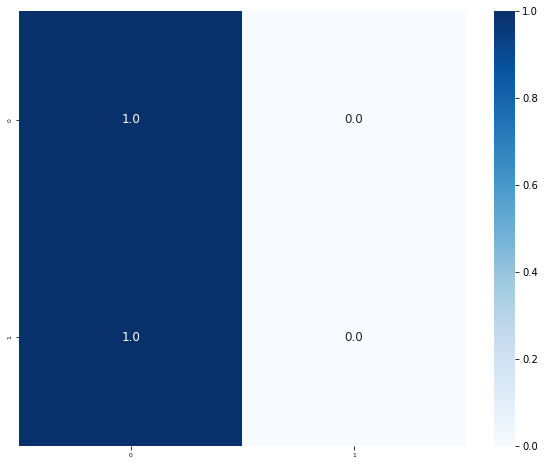

In [ ]:
import seaborn as sns
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

Accuracy for class Indian_numpy is: 100.0 %
Accuracy for class Western_numpy is: 0.0 %


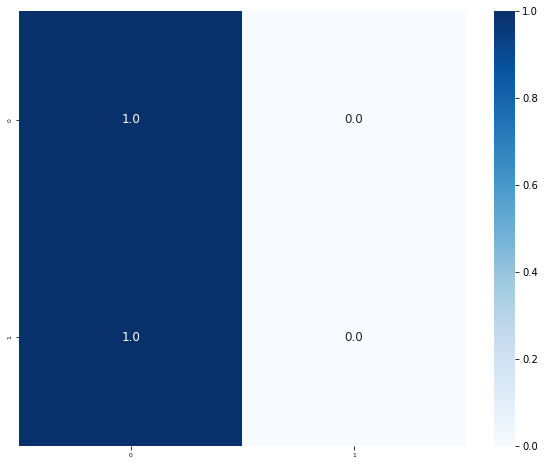

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)

# again no gradients needed
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 12},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()

In [ ]:
classes

('Indian_numpy', 'Western_numpy')

Cross validation code start

In [ ]:
files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "Western_numpy")):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk(os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

data = pd.DataFrame(files, columns=['Images','songs','labels'])
data.head()

,Images,songs,labels
0,1024.npy,1024.npy,Western_numpy
1,637.npy,637.npy,Western_numpy
2,1946.npy,1946.npy,Western_numpy
3,1282.npy,1282.npy,Western_numpy
4,1059.npy,1059.npy,Western_numpy


In [ ]:
data['encoded_labels'] = lb.transform(data['labels'])
data.head()

In [ ]:
cross_dataset = MEL_Dataset(data,os.path.join(TEST_DATA_BASE_PATH, TEST_DATA_IMG_DIR),transform)
crossloader = torch.utils.data.DataLoader(cross_dataset, batch_size=batch_size)

In [ ]:
# get some random training images
dataiter = iter(crossloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
import seaborn as sns
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
num_classes = len(classes)
cm = torch.zeros(num_classes, num_classes)

# again no gradients needed
with torch.no_grad():
    for data in crossloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            cm[label, prediction] = cm[label, prediction] + 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
fig = plt.figure(figsize=(10, 8))
confusionMatrix = cm.numpy()
confusionMatrix = confusionMatrix / confusionMatrix.astype(np.float).sum(axis=1, keepdims=True)
hmap = sns.heatmap(confusionMatrix , annot=True,
          fmt='.2', cmap='Blues', annot_kws={"size": 6},xticklabels=[0,1], yticklabels=[0,1])
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=6)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=6)
figure = hmap.get_figure()
plt.show()